In [2]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(kknn)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
players <- read_csv("data/players.csv")
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


In [4]:
players_clean <- players %>% select(experience, played_hours, age )
players_clean$experience <- factor(players_clean$experience, levels = c("Beginner","Amateur", "Regular", "Pro", "Veteran"), ordered = TRUE)
players_clean$experience <- as.numeric(players_clean$experience)
players_clean

experience,played_hours,age
<dbl>,<dbl>,<dbl>
4,30.3,9
5,3.8,17
5,0.0,17
⋮,⋮,⋮
2,0.0,17
2,2.3,17
4,0.2,91


# Data splitting

In [5]:
set.seed(2000)
players_split <- initial_split(players_clean, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [6]:
head(players_training)

experience,played_hours,age
<dbl>,<dbl>,<dbl>
5,0.0,17
3,0.1,21
2,0.0,17
⋮,⋮,⋮
2,32.0,22
4,1.7,17
2,2.3,17


In [6]:
head(players_testing)

experience,played_hours,age
<dbl>,<dbl>,<dbl>
3,0.0,19
2,0.1,17
4,0.0,17
5,0.0,17
1,0.0,17
2,0.5,17


# EDA

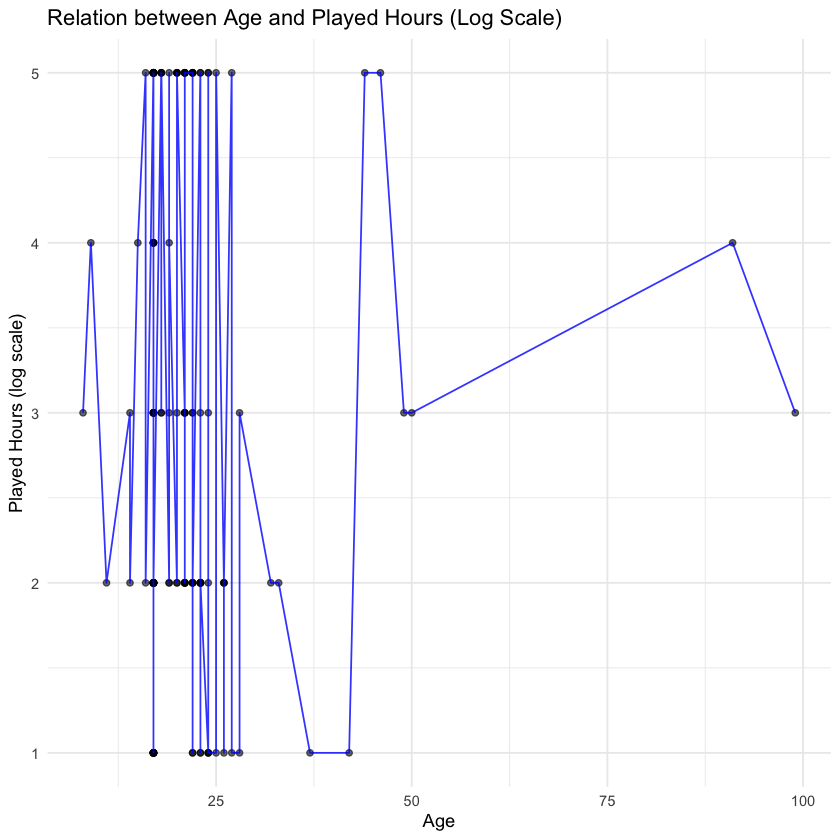

In [7]:
ggplot(players_training, aes(x = age, y = experience)) +
  geom_point(color = "black", alpha = 0.6) + 
  geom_line(color = "blue", alpha = 0.8) +  
  labs(
    title = "Relation between Age and Played Hours (Log Scale)",
    x = "Age",
    y = "Played Hours (log scale)"
  ) +
  theme_minimal()


# KNN - Training, evaluating, and tuning the model

In [8]:
players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")


In [9]:
players_recipe <- recipe( played_hours ~ ., data = players_training) |>
  step_scale(all_numeric_predictors()) |>
  step_center(all_numeric_predictors())

players_spec <- nearest_neighbor(weight_func = "rectangular",
                              neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_vfold <- vfold_cv(players_training, v =7, strata = played_hours)

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [10]:
gridvals <- tibble(neighbors = seq(from = 1, to = 110, by = 1))

players_results <- players_workflow |>
  tune_grid(resamples = players_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "rmse")

players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,8.412335,7,1.553182,Preprocessor1_Model001
2,rmse,standard,8.723314,7,1.403989,Preprocessor1_Model002
3,rmse,standard,8.586960,7,1.468142,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
108,rmse,standard,8.039834,7,1.382816,Preprocessor1_Model108
109,rmse,standard,8.037844,7,1.384241,Preprocessor1_Model109
110,rmse,standard,8.036497,7,1.386080,Preprocessor1_Model110


## Find the kmin

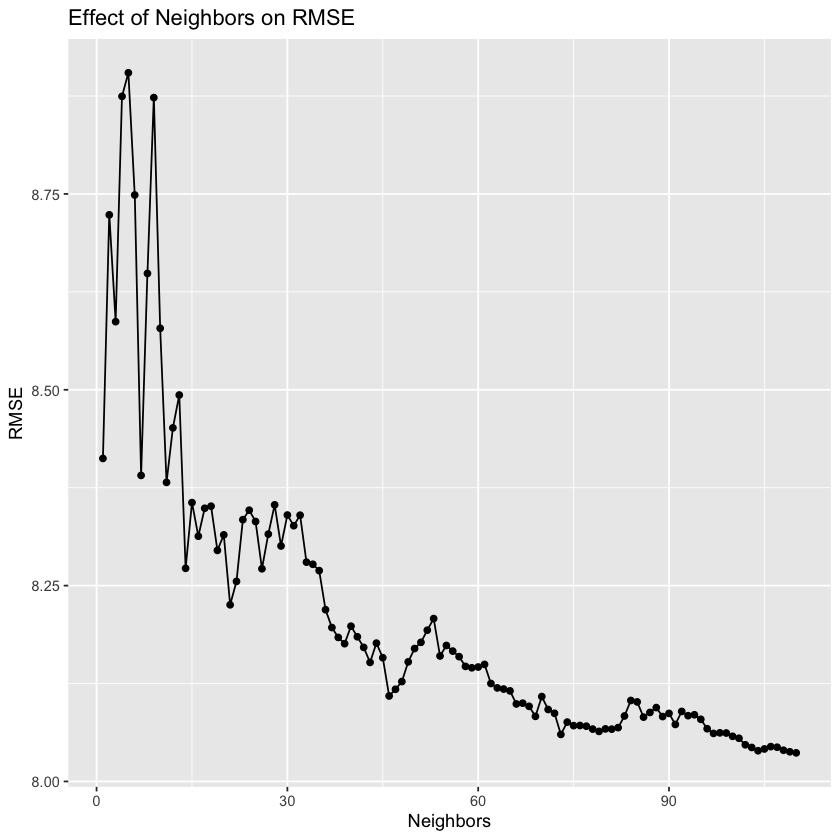

In [11]:
ggplot(players_results, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(
    title = "Effect of Neighbors on RMSE",
    x = "Neighbors",
    y = "RMSE"
  )

In [12]:
best_neighbors <- players_results |>
  filter(mean == min(mean)) |> 
  pull(neighbors)


best_neighbors

[1] 110

In [13]:
players_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_neighbors) |>
  set_engine("kknn") |>
  set_mode("regression")

players_workflow_best <- players_workflow |>
  update_model(players_spec_best)

knn_fit <- players_workflow_best |>
  fit(data = players_training)

players_testing_with_pred <- knn_fit |>
  predict(players_testing) |>
  bind_cols(players_testing)

print(players_testing_with_pred)

# A tibble: 50 × 4
   .pred experience played_hours   age
   <dbl>      <dbl>        <dbl> <dbl>
 1  2.65          3          0      19
 2  2.87          2          0.1    17
 3  2.74          4          0      17
 4  2.74          5          0      17
 5  2.87          1          0      17
 6  2.87          2          0.5    17
 7  2.87          2          0.1    17
 8  2.61          3        218.     20
 9  2.87          2          0.9    18
10  2.74          2          0.2    27
# ℹ 40 more rows


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


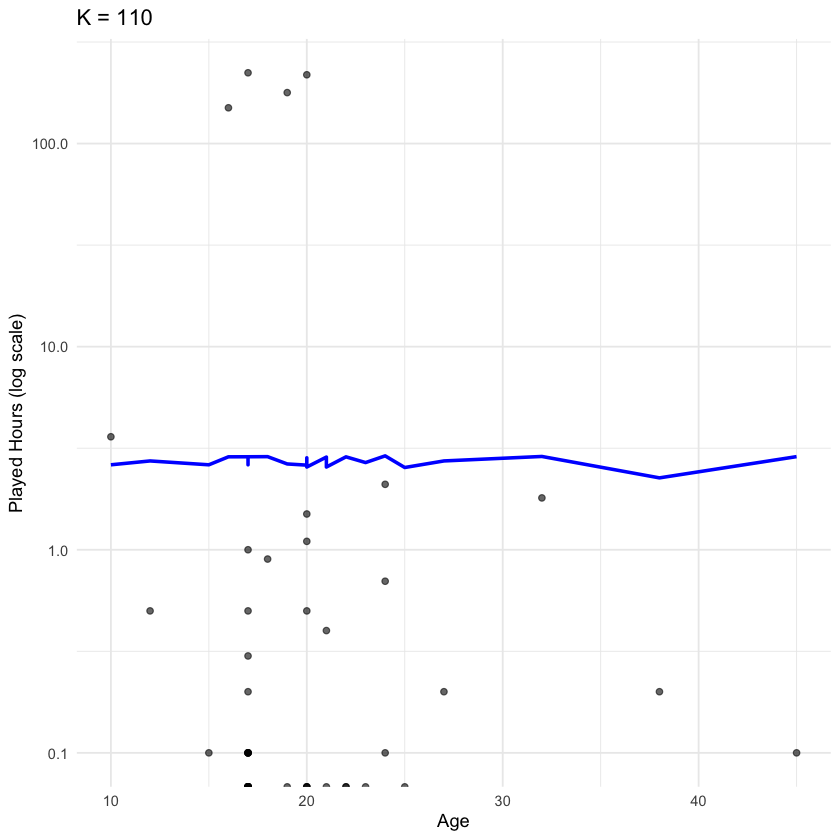

In [14]:
ggplot(players_testing_with_pred, aes(x = age, y = played_hours)) +
  geom_point(color = "black", alpha = 0.6) +  # true data points
  geom_line(aes(y = .pred), color = "blue", size = 1) +  # predicted line
  scale_y_log10() +  # Apply log scale
  labs(
    title = paste("K =", best_neighbors),  
    x = "Age",
    y = "Played Hours (log scale)"
  ) +
  theme_minimal()


# KNN - Evaluating on the test set

In [15]:

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 75) |>
set_engine("kknn") |>
  set_mode("regression")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_training)

knn_summary_testing <- knn_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')
print("Knn fit on test datas")
knn_summary_testing

knn_summary_training <- knn_fit |>
  predict(players_training) |>
  bind_cols(players_training) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

print("Knn fit on train datas")
knn_summary_training

[1] "Knn fit on test datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.14


[1] "Knn fit on train datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.66592


# LINEAR REG -  Training, evaluating, and tuning the model

In [16]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe <- recipe(played_hours ~ ., data = players_training)

lm_fit <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = players_training)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)   experience          age  
    4.91211     -0.62410     -0.02669  


In [17]:
lm_test_results <- lm_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred)|>
  filter(.metric == 'rmse')
print("Fit on test datas")
lm_test_results

lm_train_results <- lm_fit |>
  predict(players_training) |>
  bind_cols(players_training) |>
  metrics(truth = played_hours, estimate = .pred)|>
  filter(.metric == 'rmse')
print("Fit on train datas")
lm_train_results

[1] "Fit on test datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.37322


[1] "Fit on train datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.622914


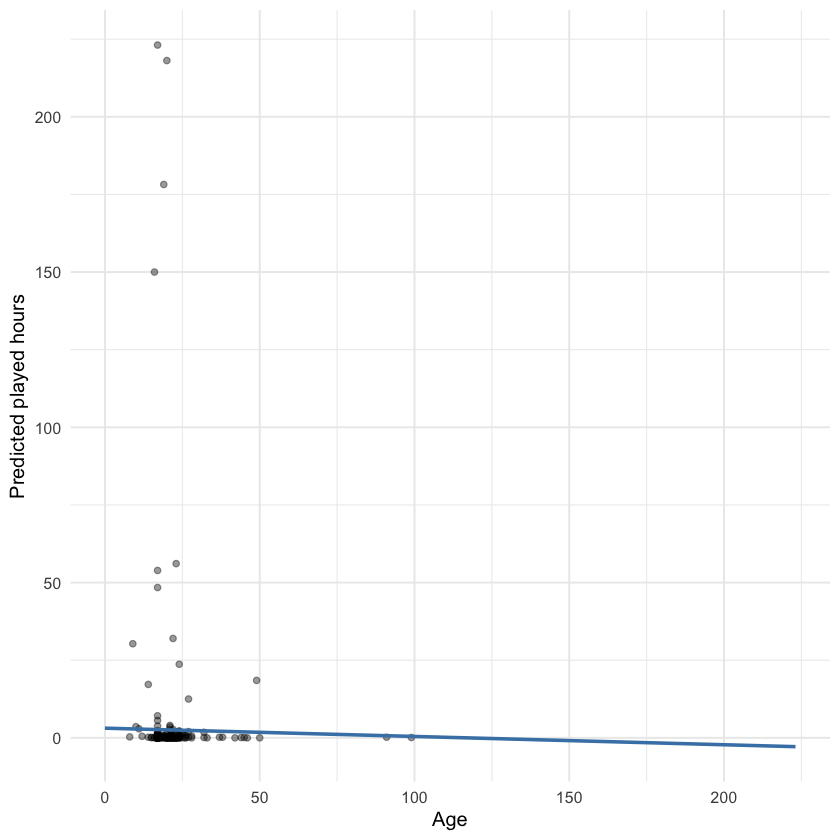

In [18]:
age_experience_grid <- tibble(
    age = seq(
        from = players_clean |> select(played_hours) |> min(),
        to = players_clean |> select(played_hours) |> max(),
        length.out = 100
    ),
    experience = mean(players_clean$experience)  # fix experience
)

age_experience_preds <- lm_fit |>
  predict(age_experience_grid) |>
  bind_cols(age_experience_grid)

lm_plot_final <- ggplot(players_clean, aes(x = age, y = played_hours)) +
  geom_point(alpha = 0.4) +  
  geom_line(data = age_experience_preds,
            mapping = aes(x = age, y = .pred),
            color = "steelblue",
            linewidth = 1) +  
  xlab("Age") +
  ylab("Predicted played hours") +
  scale_y_continuous(labels = scales::comma_format()) +  
  theme_minimal(base_size = 12)

lm_plot_final


# Final result

In [19]:

print("LM fit on train datas")
lm_train_results


[1] "LM fit on train datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.622914


In [20]:
print("LM fit on test datas")
lm_test_results



[1] "LM fit on test datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.37322


In [21]:
print("Knn fit on train datas")
knn_summary_training


[1] "Knn fit on train datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.66592


In [22]:
print("Knn fit on test datas")
knn_summary_testing

[1] "Knn fit on test datas"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,54.14
